# Initialisation
## Import modules

In [85]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats

from modules import cleanmodule as cm # pip install easymoney
from modules import visumodule # pip install seaborn
vm = visumodule.Visualiser(df)

## Import data

In [86]:
df = pd.read_csv("/Users/isar/PycharmProjects/films-data-science/datasets/films-imdb/IMDb movies.csv", low_memory=False)
df.head()
df.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

## Nettoyage data

In [87]:
print(len(df.index)) # nb rows

df['country'] = df['country'].apply(cm.clean_countries).astype('str')

df['date_published'] = df['date_published'].apply(cm.clean_dates).astype('datetime64')

df['budget'] = df.apply(cm.clean_currency, axis=1, args=["budget"]).astype('float')

df['worlwide_gross_income'] = df.apply(cm.clean_currency, axis=1, args=["worlwide_gross_income"]).astype('float')

df = df[df['reviews_from_users'] >= 1000]

df = df[df['budget'] >= 1000]

#df.loc[df['title'] == "Jeanne"]
df.head()


85855


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
3816,tt0033467,Quarto potere,Citizen Kane,1941,1948-11-25,"Drama, Mystery",119,USA,"English, Italian",Orson Welles,...,"Joseph Cotten, Dorothy Comingore, Agnes Mooreh...",Following the death of publishing tycoon Charl...,8.3,389322,7348460.68,$ 1585634,1.395005e+07,100.0,1452.0,248.0
4126,tt0034583,Casablanca,Casablanca,1942,1946-11-21,"Drama, Romance, War",102,USA,"English, French, German, Italian",Michael Curtiz,...,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical American expatriate struggles to dec...,8.5,509953,8313460.97,$ 4108411,3.828358e+07,100.0,1303.0,196.0
8973,tt0050083,La parola ai giurati,12 Angry Men,1957,1957-09-04,"Crime, Drama",96,USA,English,Sidney Lumet,...,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...,8.9,668473,3062854.04,NaN,5.040580e+03,96.0,1605.0,149.0
10455,tt0054215,Psyco,Psycho,1960,1960-10-28,"Horror, Mystery, Thriller",109,USA,English,Alfred Hitchcock,...,"Anthony Perkins, Vera Miles, John Gavin, Janet...","A Phoenix secretary embezzles $40,000 from her...",8.5,586765,7061602.52,$ 32000000,2.801080e+08,97.0,1284.0,236.0
12567,tt0060196,"Il buono, il brutto, il cattivo","Il buono, il brutto, il cattivo",1966,1966-12-23,Western,161,Italy,Italian,Sergio Leone,...,"Eli Wallach, Clint Eastwood, Lee Van Cleef, Al...",A bounty hunting scam joins two men in an unea...,8.8,672499,9568371.76,$ 25100000,2.013543e+08,90.0,1117.0,211.0


## Régression linéaire
Cherchons des correlations

In [88]:
df = df[df['duration'].notna()]
df = df[df['budget'].notna()]
df = df[df['metascore'].notna()]
df = df[df['worlwide_gross_income'].notna()]
print(len(df.index)) # nb rows

X, y = df[['duration', 'budget', 'worlwide_gross_income']], df['metascore']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

364
R-squared: 0.1762


On transforme le genre en variable dummy :

In [89]:
df.loc[:, 'un_genre'] = df.genre.map(lambda x: x.split(",")[0])



genre_df = pd.Series(df['un_genre'])
genre_df = pd.get_dummies(genre_df.apply(pd.Series).stack()).sum(level=0)
df_avec_genre = pd.concat([df,genre_df], axis=1)
#df_avec_genre.head()
df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,un_genre
3816,tt0033467,Quarto potere,Citizen Kane,1941,1948-11-25,"Drama, Mystery",119,USA,"English, Italian",Orson Welles,...,Following the death of publishing tycoon Charl...,8.3,389322,7348460.68,$ 1585634,1.395005e+07,100.0,1452.0,248.0,Drama
4126,tt0034583,Casablanca,Casablanca,1942,1946-11-21,"Drama, Romance, War",102,USA,"English, French, German, Italian",Michael Curtiz,...,A cynical American expatriate struggles to dec...,8.5,509953,8313460.97,$ 4108411,3.828358e+07,100.0,1303.0,196.0,Drama
8973,tt0050083,La parola ai giurati,12 Angry Men,1957,1957-09-04,"Crime, Drama",96,USA,English,Sidney Lumet,...,A jury holdout attempts to prevent a miscarria...,8.9,668473,3062854.04,NaN,5.040580e+03,96.0,1605.0,149.0,Crime
10455,tt0054215,Psyco,Psycho,1960,1960-10-28,"Horror, Mystery, Thriller",109,USA,English,Alfred Hitchcock,...,"A Phoenix secretary embezzles $40,000 from her...",8.5,586765,7061602.52,$ 32000000,2.801080e+08,97.0,1284.0,236.0,Horror
12567,tt0060196,"Il buono, il brutto, il cattivo","Il buono, il brutto, il cattivo",1966,1966-12-23,Western,161,Italy,Italian,Sergio Leone,...,A bounty hunting scam joins two men in an unea...,8.8,672499,9568371.76,$ 25100000,2.013543e+08,90.0,1117.0,211.0,Western


In [90]:
X, y = df_avec_genre[['duration','budget','Drama', 'Comedy']], df_avec_genre['worlwide_gross_income']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.3479


## Entraînement modèle régression linéaire

Coefficients: 
 [3.80436039]
Mean squared error: 160207047167183520.00
Coefficient of determination: 0.27


<IPython.core.display.Javascript object>


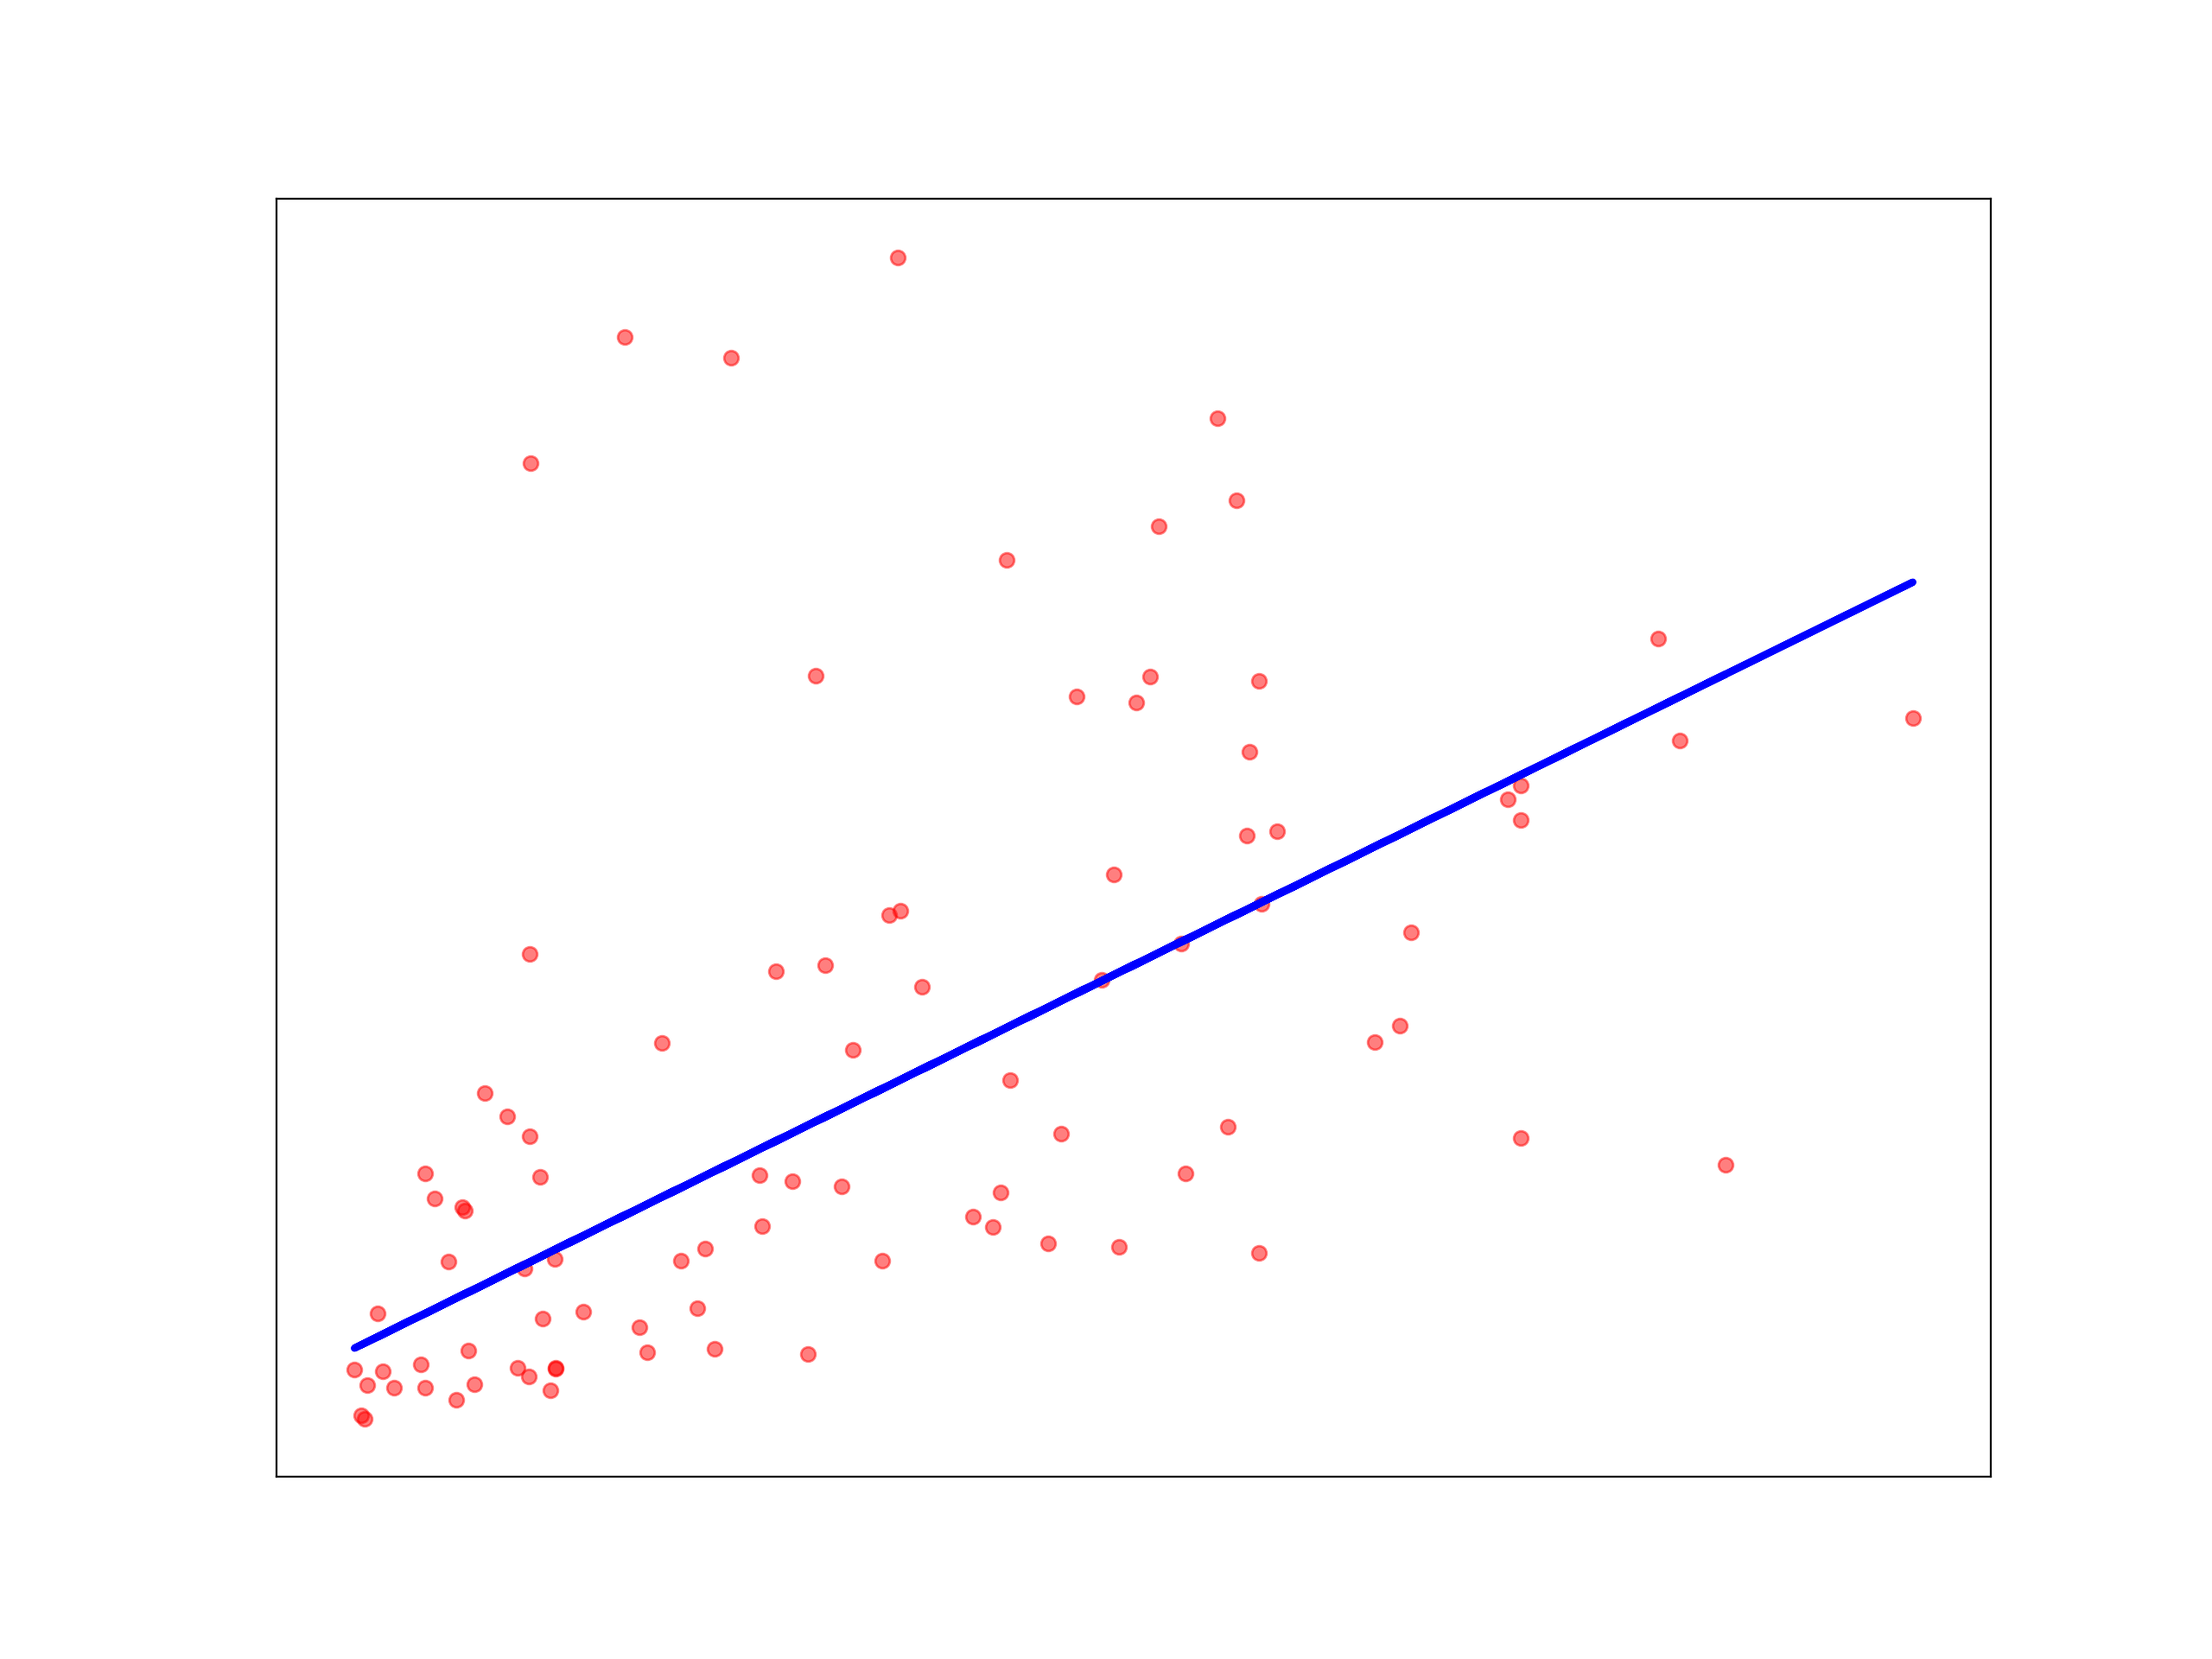

In [97]:
X, y = df_avec_genre[['budget']], df_avec_genre['worlwide_gross_income']
lre = LinearRegression()



x_train, x_test, y_train, y_test = train_test_split(X, y)

lre.fit(x_train, y_train)

#print('R-squared: {:.4f}'.format(lr.score(x_train, y_train)))

y_pred = lre.predict(x_test)

# The coeff
print('Coefficients: \n', lre.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(x_test, y_test,  color='red', alpha=0.5)
plt.plot(x_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
# belle prez si viz pour mise en contexte
# todo predict financial success using regr in new notebook